# Исследование закономерности успешности компьютерных игр

У нас есть данные из открытых источников до 2016 года: продажи игр, оценки пользователей и экспертов, жанры и платформы. Мы будем выявлять определяющие успешность игр закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.<br><br>
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Открываем файл с данными и изучаем общую информацию

### Импортируем библиотеки

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

### Открываем и изучаем файл с данными

In [2]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
#df
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


### Описание данных

 - Name — название игры<br>
 - Platform — платформа<br>
 - Year_of_Release — год выпуска<br>
 - Genre — жанр игры<br>
 - NA_sales — продажи в Северной Америке (миллионы проданных копий)<br>
 - EU_sales — продажи в Европе (миллионы проданных копий)<br>
 - JP_sales — продажи в Японии (миллионы проданных копий)<br>
 - Other_sales — продажи в других странах (миллионы проданных копий)<br>
 - Critic_Score — оценка критиков (максимум 100)<br>
 - User_Score — оценка пользователей (максимум 10)<br>
 - Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Вывод

Исходные данные представляют собой таблицу (16715 rows × 11 columns). Таблица имеет пропуски, больше всего в столбцах рейтинга и оценок критиков и пользователей. Столбцы продаж имеют очень много нулевых значений (у некоторых 25% и 50% квантили равны 0), это не аномалия, скорее всего какие-то игры продавались только в каких-то определенных регионах.

## Предобработка данных

### Приводим названия столбцов к нижнему регистру

In [6]:
df.columns = df.columns.str.lower()
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Проверим на наличие дубликатов

In [7]:
df.loc[df.duplicated(subset=['name','platform','year_of_release'], keep=False) == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


Итак мы нашли несколько дубликатов. Давайте разбираться по порядку.
1. Дубликаты с пропусками в названии, рейтинге и оценках мы удалим позднее, т.к. они практически не несут никакой ценности для нас.
2. Дубликат Madden NFL 13 -	PS3 - 2012. Это может быть аномалией при выгрузке или каким-то коллекционным изданием, которое продавалось только в Европе с маленьким тиражом. Т.к. в названии ни у одной игры нет признаков коллекционных изданий, будем считать это аномалией выгрузки и удалим эту строку. Дополнительно, можно было бы увеличить значение eu_sales у игры Madden NFL 13 на приставке PS3 в 2012 году на 0.01, которое мы дропнули при удалении дубликата, но я не считаю это нужным, т.к. в любом случае значения настолько малы в размерах всего датафрейма, что они не повлияют на дальнейшее исследование.

In [8]:
df = df.drop(df.index[16230]).reset_index(drop=True)

### Обрабатываем пропуски и меняем типы данных

#### Cтолбец name

In [9]:
df.loc[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В столбце name 2 пропуска, причем вся информация, кроме продаж в регионах и года выпуска, отсутствует. Скорее всего это связано с тем, что игра слишком старая и по ней есть только статистика продаж. Удалим эти строки, они не повлияют на исследование.

In [10]:
df.dropna(subset=['name'], inplace=True)
df.reset_index(drop=True, inplace=True)

#### Cтолбец year_of_release

In [11]:
df.loc[df['year_of_release'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16370,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16402,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16445,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16455,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


В столбце year_of_release 269 пропусков (это 1,6 % от всех исходных данных). Предлагаю их удалить, т.к. они не сильно повлияют на результат исследования. Т.к. все значения целые, то поменяем тип данных на int.

In [12]:
df.dropna(subset=['year_of_release'], inplace=True)
df.reset_index(drop=True, inplace=True)
df['year_of_release'] = df['year_of_release'].astype(int)
df.shape

(16443, 11)

#### Cтолбец rating

Рейтинг ESRB (Entertainment Software Rating Board) имеет несколько значений:
- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех» (первоначально "K-A" ("Kids to Adults"))
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») — «Только для взрослых»
- «RP» («Rating Pending») — «Рейтинг ожидается»
- «RP 17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+»

Посмотрим, какие значения ESRB встречаются у нас.

In [13]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Т.к. "K-A" уже вывели из обращения, то заменим его на значение «E», а всем пропускам присвоим заглушку - значение No Rating.

In [14]:
df.loc[df['rating'] == 'K-A', 'rating'] = 'E'
df.loc[df['rating'].isna(), 'rating'] = 'No Rating'

#### Столбцы critic_score и user_score

In [15]:
df.loc[df['critic_score'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,No Rating
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,No Rating
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,No Rating
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,No Rating
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,No Rating
...,...,...,...,...,...,...,...,...,...,...,...
16438,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,No Rating
16439,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,No Rating
16440,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,No Rating
16441,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,No Rating


В столбце critic_score 8461 пропуск (это более 50%). Такой объем данных может повлиять на исследование. Эти пропуски стоит либо как-то точечно заменить, либо поставить заглушку. Попробуем создать сводную таблицу из медианных значений оценок критиков так, чтобы столбцами были жанры, а индекс - платформы.

Оценим пропуски в столбце user_score

In [21]:
df['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.1       2
0.9       2
0.2       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Заменим значение tbd (To Be Determined - будет определено позже) в столбце user_score на NaN. Изменим тип столбца на float.

In [22]:
df.loc[df['user_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,No Rating
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,No Rating
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,No Rating
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,No Rating
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,No Rating
...,...,...,...,...,...,...,...,...,...,...,...
16438,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,No Rating
16439,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,No Rating
16440,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,No Rating
16441,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,No Rating


Попробуем заполнить 6605 пропусков в столбце user_score по аналогии со столбцом critic_score.

In [23]:
df['user_score'] = df['user_score'].replace('tbd','NaN')
df['user_score'] = df['user_score'].astype('float64')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Вернемся ко срезу, где у игр вместо оценок были пропуски и попробуем проанализировать его.

In [28]:
score_nan = df.loc[df['user_score'].isna() | df['critic_score'].isna()]
score_nan

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,No Rating
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,No Rating
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,No Rating
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,No Rating
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,No Rating
...,...,...,...,...,...,...,...,...,...,...,...
16438,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,No Rating
16439,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,No Rating
16440,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,No Rating
16441,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,No Rating


Визуализируем количество игр без оценок сгруппировав их по годам выпуска.

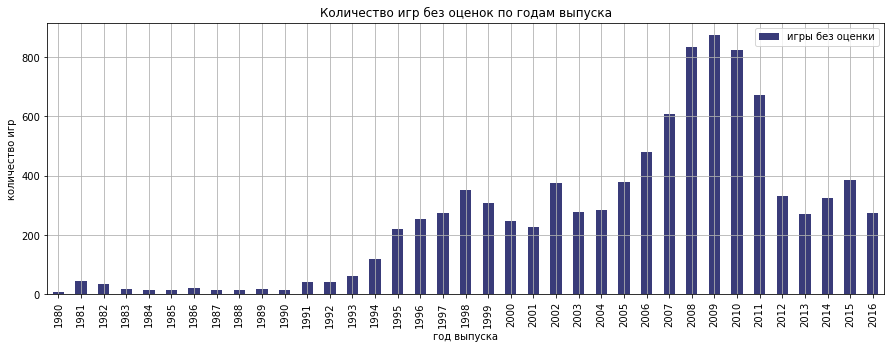

In [29]:
score_nan_by_year = score_nan['year_of_release'].value_counts().reset_index().rename(columns = {"index" : "год","year_of_release" : "игры без оценки"}).sort_values(by='год')
score_nan_by_year.plot(
    kind='bar', 
    x='год', 
    grid=True, 
    figsize=(15,5),
    colormap= 'tab20b',
    title='Количество игр без оценок по годам выпуска', 
    ylabel='количество игр', 
    xlabel='год выпуска')

plt.show()

Мы видим, что после 2001 года наш способ замены пропусков смог обработать практически все пропуски. Наличие значений до 2001 года говорит о том, что в исходном датафрейме недостаточно данных для формирования медианной сводной таблицы. Скорее всего это связано с низким количеством выпускаемых игр или отсутствием статистики для них.<br><br>
Давайте рассмотрим распределение выпуска игр по годам.

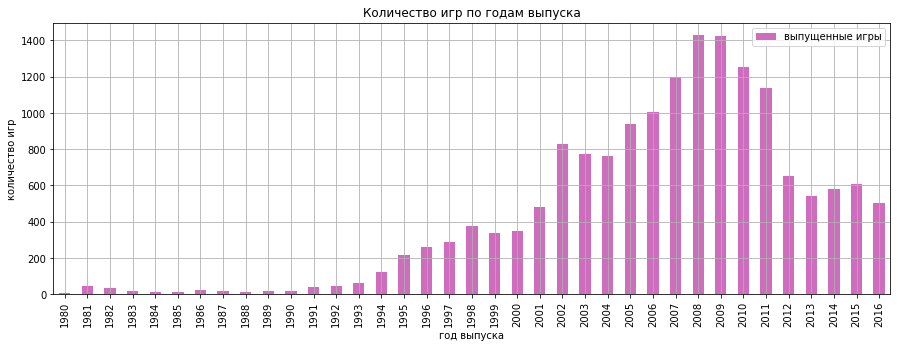

In [30]:
games_by_year = df['year_of_release'].value_counts().reset_index().rename(columns = {"index" : "год","year_of_release" : "выпущенные игры"}).sort_values(by='год')

games_by_year.plot(
    kind='bar', 
    x='год', 
    grid=True, 
    figsize=(15,5),
    color= '#ce6dbd',
    title='Количество игр по годам выпуска', 
    ylabel='количество игр', 
    xlabel='год выпуска')

plt.show()

Ожидания подтвердились, с 1994 года количество выпускаемых игр в год начинает резко увеличиваться. Давайте наложим эти графики друг на друга.

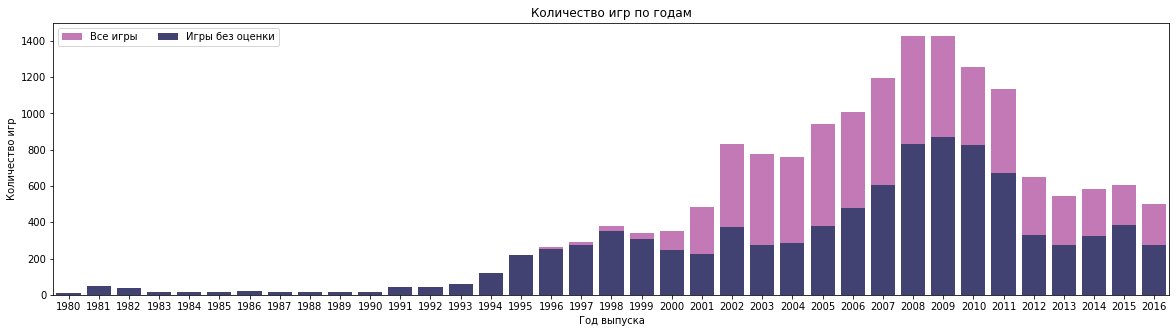

In [31]:
f, ax = plt.subplots(figsize=(20,5))

sns.barplot(
    x='год', 
    y='выпущенные игры', 
    data=games_by_year, 
    label='Все игры',
    color='#ce6dbd'
).set_title('Количество игр по годам')

sns.barplot(
    x='год', 
    y='игры без оценки', 
    data=score_nan_by_year, 
    label='Игры без оценки',
    color='#393b79')

ax.legend(
    ncol=2, 
    loc="best", 
    frameon=True)

ax.set(
    ylabel='Количество игр',
    xlabel='Год выпуска')

plt.show()

Мы видим, что с 1980 по 1993 годы практически все игры не имеют оценок. Далее начинается резкий рост количества выпускаемых в год игр. Отрасль развивается, люди начинают больше принимать в ней участия и оценивают игры. Либо при формировании исходного датафрейма не смогли найти в открытых источниках оценки для этих игр. Оставшиеся пропуски в столбцах critic_score и user_score заполнять значениями было бы не правильно. Можно поставить заглушку (например, '-1'), но я предлагаю оставить как есть, а при необходимости будем работать со срезами данных.

### Создаем столбец с суммарными продажами по всем регионам

In [32]:
df['world_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

### Вывод

В ходе предобработки данных мы:<br>
Привели названия столбцов к нижнему регистру.<br>
Нашли и удалили 1 дубликат.<br>
Создали столбец 'world_sales' с суммарными продажами во всех регионах.<br>
Изменили типы данных: в столбце 'year_of_release' на int64, а в столбце 'user_score' на float64.<br>
Обработали пропуски: 
- в столбце 'name' удалили 2 пропуска, а в столбце 'year_of_release' 269 пропусков (1,6%). Такое количество не должно повлиять на результат исследования.
- в столбце 'rating' заменили устаревшее значение 'K-A' на современное 'E'. Пропуски заменили заглушкой 'No Rating'.
- в столбцах 'critic_score' и 'user_score' не смогли найти удовлетворяющее нас решение для замены пропусков, поэтому пропуски не стали трогать, при необходимости будем работать со срезами.

##  Исследовательский анализ данных

### Проанализиуем сколько игр выпускалось в разные годы и важны ли данные за все периоды.

Мы уже строили график распределения выпуска игр по годам. Еще раз обратимся к нему.

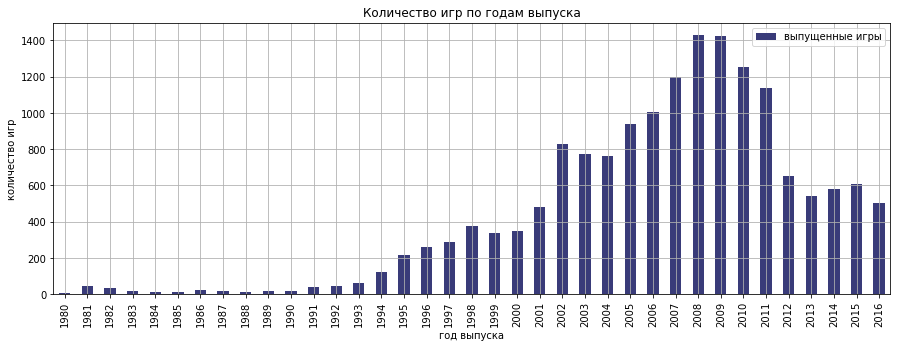

In [33]:
games_by_year.plot(
    kind='bar', 
    x='год',
    grid=True, 
    figsize=(15,5),
    colormap= 'tab20b',
    title='Количество игр по годам выпуска', 
    ylabel='количество игр', 
    xlabel='год выпуска'
)
plt.show()

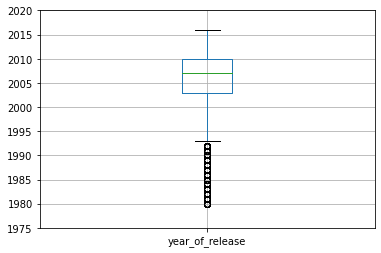

In [34]:
plt.ylim(1975,2020)
df.boxplot(column='year_of_release') 
plt.show()

In [35]:
df['year_of_release'].describe()

count    16443.000000
mean      2006.485921
std          5.875546
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

По диаграмме размаха видно, что наблюдаемый максимум примерно на уровне 2016 года, а наблюдаемый минимум примерно на уровне 1993 года. Значения с 1980 по 1993 года можно считать выбросами. Визуально это соответствует получившемуся графику. 
 - с 1980 по 1993 года можно не учитывать. 
 - с 1994 по 2008 года мы наблюдаем рост количества выпускаемых игр. 
 - 2008 и 2009 года - это наши максимумы, там выпускалось больше всего игр.
 - с 2009 по 2013 года идет спад в выпуске игр.
 - с 2013 по 2016 года количество выпускаемых игр остается примерно на одном уровне.

### Проанализируем, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Найдем за какой характерный срок появляются новые и исчезают старые платформы.

In [36]:
sales_by_platform = df.pivot_table(
    index=['platform'],
    values='world_sales',
    aggfunc='sum'
)

sales_by_platform = sales_by_platform.sort_values(by='world_sales',ascending = False)

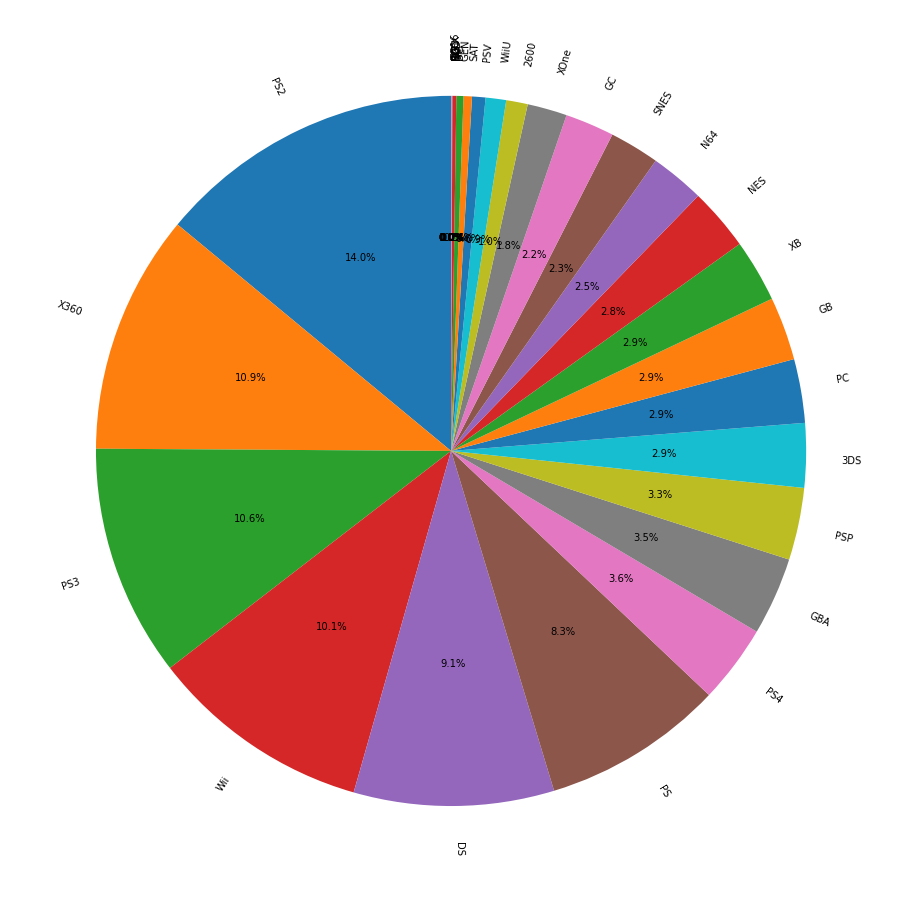

In [37]:
plt.figure(figsize=(35,35))

plt.subplot(121)

plt.pie(
    sales_by_platform['world_sales'],
    labels=sales_by_platform.index,
    autopct='%1.1f%%',
    startangle=90,
    rotatelabels=True)

plt.show()

In [38]:
sales_by_platform.head(10)

,world_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.33
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [39]:
top10_platform = sales_by_platform.head(10).index
top10_platform

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS'], dtype='object', name='platform')

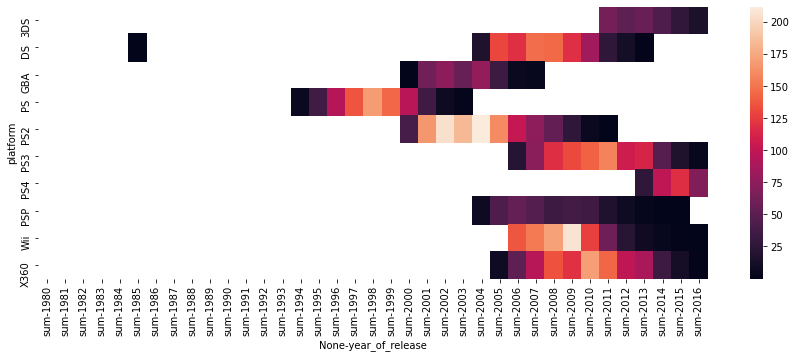

In [40]:
sum_sales_by_platform_year=df.pivot_table(
    index='platform',
    columns='year_of_release',
    values='world_sales',
    aggfunc={sum})

sum_sales_by_top10_platform_year = sum_sales_by_platform_year.query('platform in @top10_platform')

plt.figure(figsize=(15,5))
sns.heatmap(sum_sales_by_top10_platform_year);

Мы выделили 10 платформ с самыми высокими продажами и сделали хитмап для анализа. По грфику видно, что в среднем платформа живет 10-12 лет. При этом характерна ситуация, когда рост продаж меняется спадом в год выхода следующей версии платформы (наглядно видно на примере PS - PS2 - PS3 - PS4).

### Определим актуальный период, за который возьмем данные для формирования прогноза на 2017 год.

Ранее мы уже определили, что средний жизненный цикл платформ 10-12 лет. Поэтому актуальный период определим с 2005 по 2016 год.

In [41]:
df_actual = df.query('year_of_release > 2013')
df_actual.reset_index(drop=True, inplace=True)
df_actual

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,No Rating,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,No Rating,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,No Rating,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
1684,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,No Rating,0.01
1685,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,No Rating,0.01
1686,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,No Rating,0.01
1687,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,No Rating,0.01


### Проанализируем платформы по продажам за актуальный период и выберем несколько потенциально прибыльных.

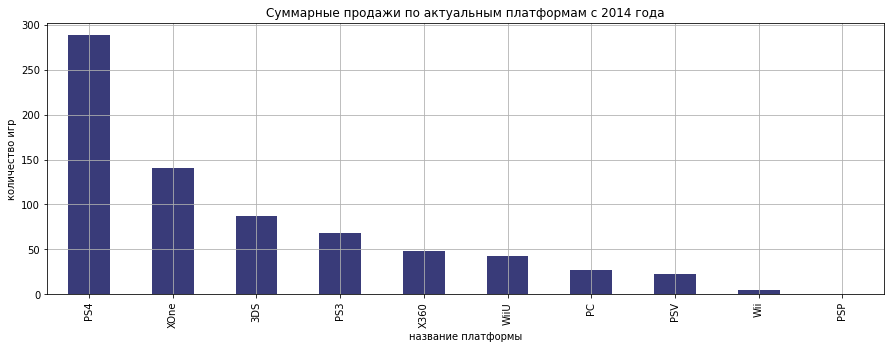

In [42]:
actual_world_sales_by_platform = df_actual.groupby('platform')['world_sales'].sum().sort_values(ascending=False)

actual_world_sales_by_platform.plot(
    figsize=(15,5),
    kind="bar",
    colormap= 'tab20b',
    grid=True,
    title='Суммарные продажи по актуальным платформам с 2014 года',
    ylabel='количество игр', 
    xlabel='название платформы');

Мы видим несколько лидеров по продажам за 3 года (PS4, ХOne, 3DS). Давайте проанализируем динамику продаж по годам.

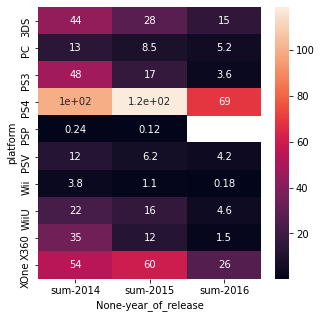

In [43]:
actual_sum_sales_by_platform_year=df_actual.pivot_table(
    index='platform',
    columns='year_of_release',
    values='world_sales',
    aggfunc={sum})

plt.figure(figsize=(5,5))
sns.heatmap(actual_sum_sales_by_platform_year, annot = True);

In [44]:
df_actual.loc[df_actual['year_of_release'] == 2016].pivot_table(
    index='platform',
    columns='year_of_release',
    values='world_sales',
    aggfunc={sum})

,sum
year_of_release,2016
platform,
3DS,15.14
PC,5.25
PS3,3.60
PS4,69.25
PSV,4.25
Wii,0.18
WiiU,4.60
X360,1.52


По хитмапу мы видим, что в 2016 году потенциально прибыльные платформы: PS4, XOne и 3DS. При этом продажи игр у XOne и 3DS уже несколько лет падают и время жизни этих платформ подходит к концу, а у PS4 продажи только начали падать, значит еще несколько лет платформа еще будет актуальна и скоро выйдет следующее поколение этой платформы.

### Проанализируем «ящик с усами» по глобальным продажам игр в разбивке по платформам.

Тут мне немного не понятно, что имелось ввиду под словосочетанием "глобальные продажи игр". Исходим из того, что просят проанализировать "ящик с усами", значит исходный датафрейм - это массив каких-то дисперсий. Разбивка должна быть по платформам, анализировать надо глобальные продажи игр. На ум приходит только взять столбец суммарных продаж по регионам для каждой игры и отобразить на графике его разбивку по платформам.

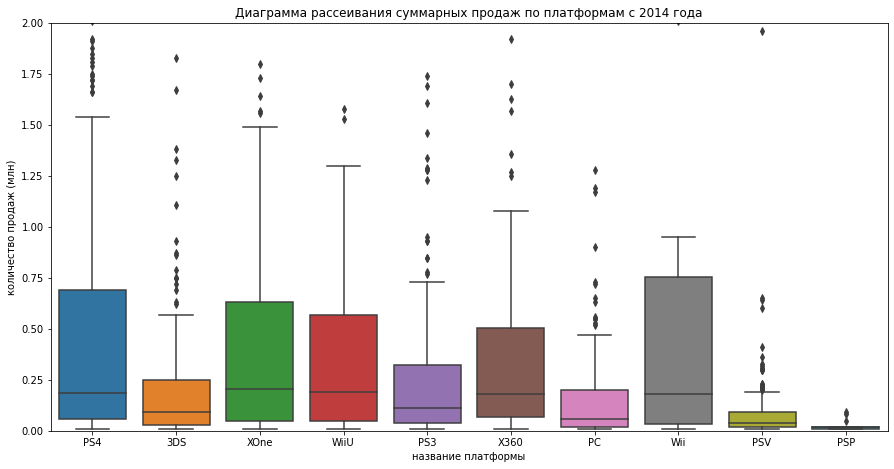

In [45]:
plt.figure(figsize=(15,7.5))
plt.ylim(0,2)
sns.boxplot(
    data=df_actual,
    x='platform',
    y='world_sales'
).set_title('Диаграмма рассеивания суммарных продаж по платформам с 2014 года')

plt.ylabel('количество продаж (млн)')
plt.xlabel('название платформы');

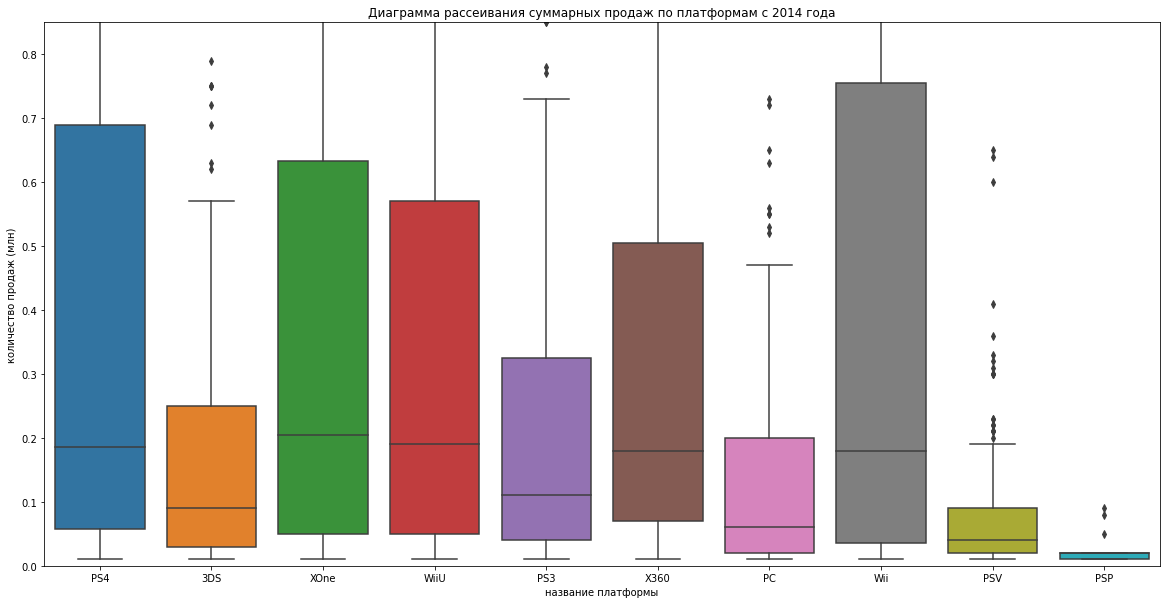

In [46]:
plt.figure(figsize=(20,10))
plt.ylim(0,0.85)
sns.boxplot(
    data=df_actual,
    x='platform',
    y='world_sales'
).set_title('Диаграмма рассеивания суммарных продаж по платформам с 2014 года')

plt.ylabel('количество продаж (млн)')
plt.xlabel('название платформы');

На диаграмме рассеивания мы видим 10 платформ. Для всех (кроме PSP, у нее скорее всего мало значений для анализа) характерно смещение вверх, а значит среднее значение продаж выше медианного. Так же для всех характерны выбросы, что говорит о дисперсии данных. Чем выше находится верхний квартиль и максимальное значение, тем больше копий игр продается на этой платформе. Среди таких платформы X360, WiiU, PS4, XOne и Wii. При этом стоит учитывать, что диаграмма не учитывает количество уникальных игр, продаваемых на платформе.

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируйте выводы.

#### Рассмотрим платформу PS3 

In [47]:
#actual_ps3_sales = df_actual.query('platform == "PS3" & critic_score > 0 & user_score > 0')
actual_ps3_sales = df_actual.query('platform == "PS3"')

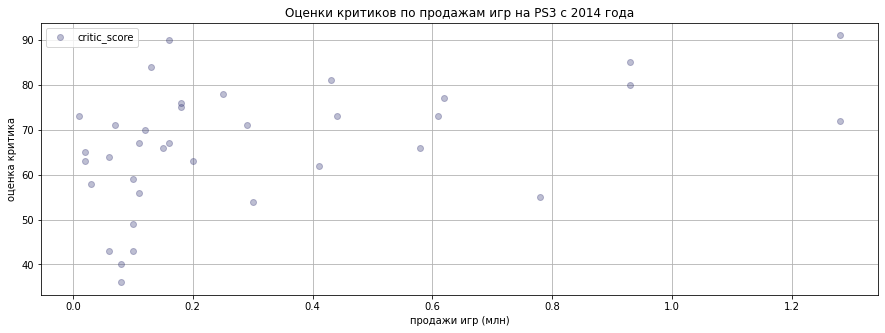

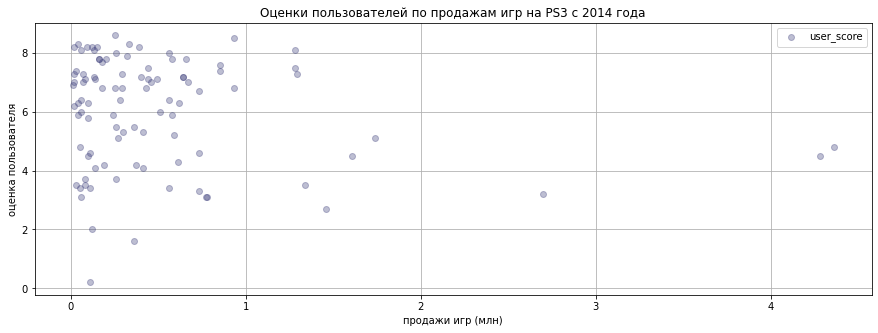

In [48]:
(actual_ps3_sales
 
     .sort_values(
         by='critic_score',
         ascending=True
     )
 
    .plot(
        x='world_sales',
        y='critic_score',
        grid=True,
        style='o',
        alpha=0.33,
        colormap= 'tab20b',
        figsize=(15,5),
        title='Оценки критиков по продажам игр на PS3 с 2014 года',
        ylabel='оценка критика',
        xlabel='продажи игр (млн)')
);

(actual_ps3_sales
 
 .sort_values(
     by='user_score',
     ascending=True
 )
    
 .plot(
     x='world_sales',
     y='user_score',
     grid=True,
     style='o',
     alpha=0.33,
     colormap= 'tab20b',
     figsize=(15,5),
     title='Оценки пользователей по продажам игр на PS3 с 2014 года',
     ylabel='оценка пользователя',
     xlabel='продажи игр (млн)')
);

Считаем коэффициентов корреляции

In [49]:
actual_ps3_sales['world_sales'].corr(actual_ps3_sales['critic_score'])

0.44657460493190704

In [50]:
actual_ps3_sales['world_sales'].corr(actual_ps3_sales['user_score'])

-0.16676141347662116

Коэф. корреляции между продажами и оценкой критиков: 0,44 , что соответствует средне-слабой зависимости.<br>
Коэф. корреляции между продажами и оценкой пользователей: - 0,16 , что соответствует отсутствию зависимости.

#### Рассмотрим платформу PS4

In [51]:
actual_ps4_sales = df_actual.query('platform == "PS4"')

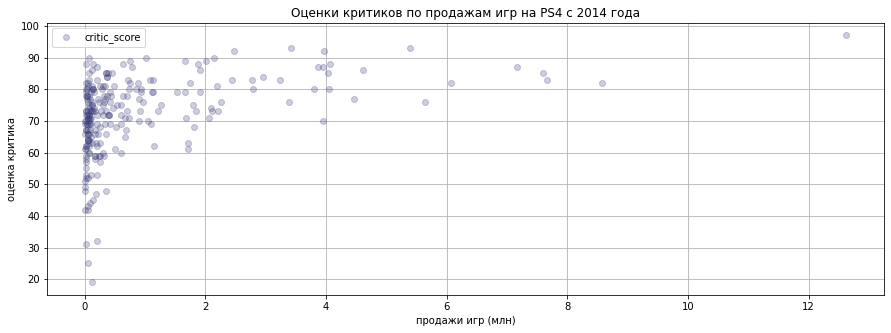

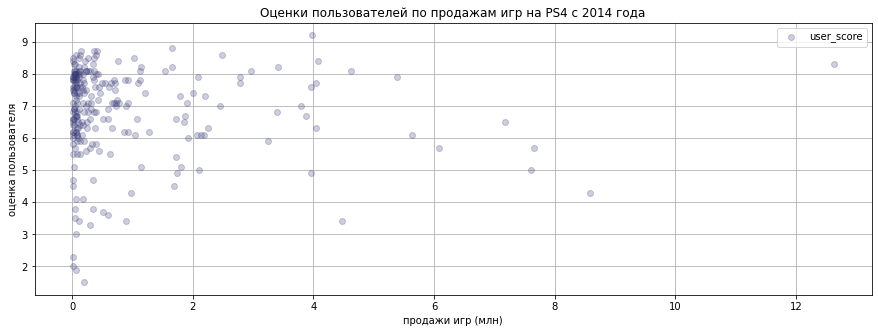

In [52]:
(actual_ps4_sales
 .sort_values(by='critic_score',ascending=True)
 .plot(
     x='world_sales',
     y='critic_score',
     grid=True,
     style='o',
     alpha=0.25,
     colormap= 'tab20b',
     figsize=(15,5),
     title='Оценки критиков по продажам игр на PS4 с 2014 года',
     ylabel='оценка критика',
     xlabel='продажи игр (млн)')
);

(actual_ps4_sales
 .sort_values(by='user_score',ascending=True)
 .plot(
     x='world_sales',
     y='user_score',
     grid=True,
     style='o',
     alpha=0.25,
     colormap= 'tab20b',
     figsize=(15,5),
     title='Оценки пользователей по продажам игр на PS4 с 2014 года',
     ylabel='оценка пользователя',
     xlabel='продажи игр (млн)')
);

In [53]:
actual_ps4_sales['world_sales'].corr(actual_ps4_sales['critic_score'])

0.40266141068104083

In [54]:
actual_ps4_sales['world_sales'].corr(actual_ps4_sales['user_score'])

-0.040131589472697356

Коэф. корреляции между продажами и оценкой критиков: 0,40 , что соответствует средне-слабой зависимости.<br>
Коэф. корреляции между продажами и оценкой пользователей: - 0,04 , что соответствует отсутствию зависимости.

#### Рассмотрим платформу XOne

In [55]:
actual_xone_sales = df_actual.query('platform == "XOne"')

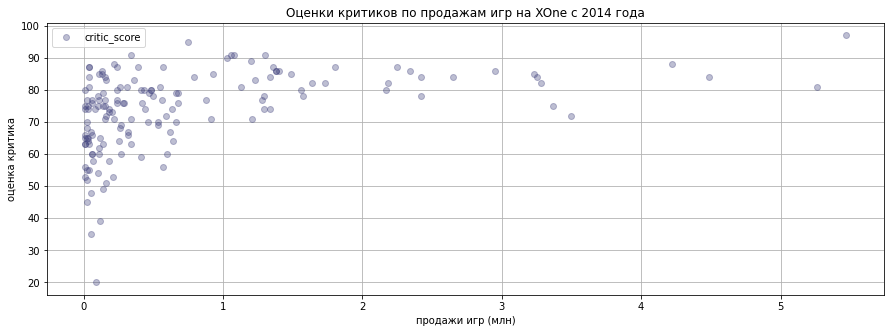

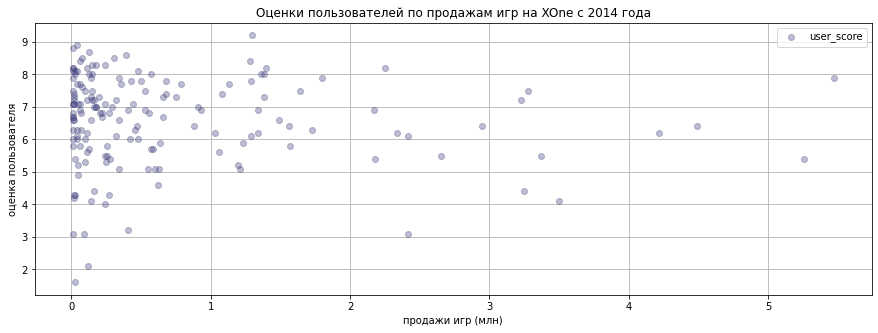

In [56]:
(actual_xone_sales
 .sort_values(by='critic_score',ascending=True) 
 .plot(
     x='world_sales',
     y='critic_score',
     grid=True,
     style='o',
     alpha=0.33,
     colormap= 'tab20b',
     figsize=(15,5),
     title='Оценки критиков по продажам игр на XOne с 2014 года',
     ylabel='оценка критика',
     xlabel='продажи игр (млн)')
);

(actual_xone_sales
 .sort_values(by='user_score',ascending=True)
 .plot(
     x='world_sales',
     y='user_score',
     grid=True,
     style='o',
     alpha=0.33,
     colormap= 'tab20b',
     figsize=(15,5),
     title='Оценки пользователей по продажам игр на XOne с 2014 года',
     ylabel='оценка пользователя',
     xlabel='продажи игр (млн)')
);

In [57]:
actual_xone_sales['world_sales'].corr(actual_xone_sales['critic_score'])

0.42867694370333226

In [58]:
actual_xone_sales['world_sales'].corr(actual_xone_sales['user_score'])

-0.0703839280647581

Коэф. корреляции между продажами и оценкой критиков: 0,42 , что соответствует средне-слабой зависимости.<br>
Коэф. корреляции между продажами и оценкой пользователей: - 0,07 , что соответствует отсутствию зависимости.

#### Вывод

Мы рассмотрели 3 популярные платформы (PS3, PS4 и XOne), для каждой проанализировали коэф. корреляции продаж игр от оценок критиков и пользователей. И сделали вывод, что:
 - Оценки критиков демонстрируют прямую, средне-слабую корреляцию с "цифрами" продаж.
 - Оценки пользователей корреляции с продажами не имеют.

### Посмотрим на общее распределение игр по жанрам. Проанализируем самые прибыльные жанры и зависимости жанров с высокими и низкими продажами.

In [59]:
actual_sales_by_genre = df_actual.pivot_table(
    index = ['genre'],
    values = 'world_sales',
    aggfunc = 'sum')

,world_sales
genre,
Action,199.36
Shooter,170.94
Sports,109.48
Role-Playing,101.44
Misc,37.55
Fighting,28.22
Racing,27.52
Platform,18.09
Adventure,17.55


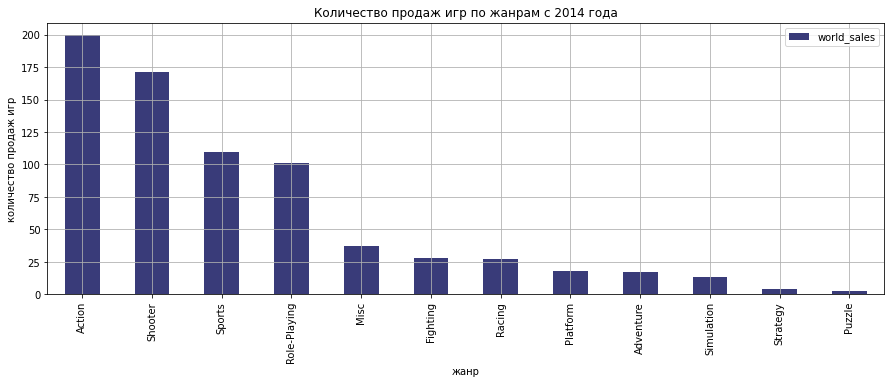

In [60]:
actual_sales_by_genre.sort_values('world_sales',ascending=False).plot(
    y='world_sales',
    grid=True,
    figsize=(15,5),
    kind='bar',
    colormap= 'tab20b',
    ylabel='количество продаж игр',
    xlabel='жанр',
    title='Количество продаж игр по жанрам с 2014 года');

actual_sales_by_genre.sort_values('world_sales',ascending=False)

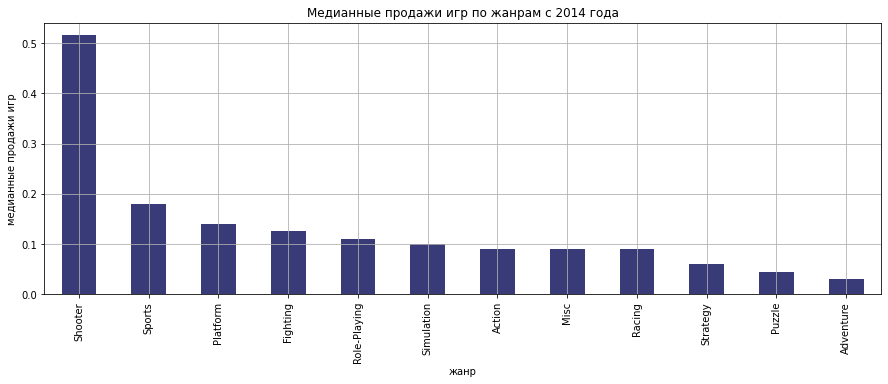

In [61]:
actual_median_sales_by_genre = df_actual.groupby('genre')['world_sales'].median().sort_values(ascending=False)

actual_median_sales_by_genre.plot(
    y='genre',
    grid=True,
    figsize=(15,5),
    kind='bar',
    colormap= 'tab20b',
    ylabel='медианные продажи игр',
    xlabel='жанр',
    title='Медианные продажи игр по жанрам с 2014 года');

In [62]:
actual_sales_by_genre_year = df_actual.pivot_table(
    index=['genre', 'year_of_release'],
    values='world_sales',
    aggfunc='sum'
)

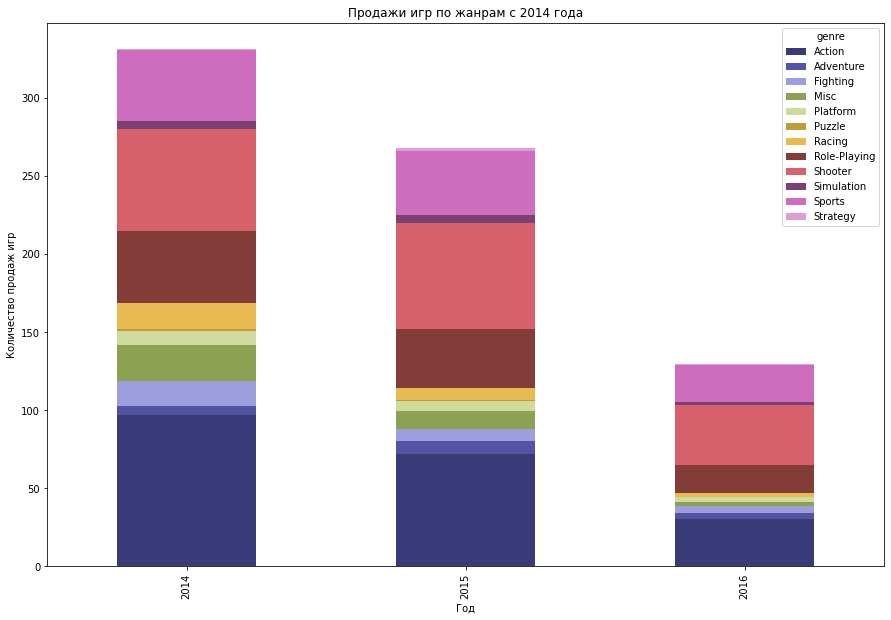

In [63]:
actual_sales_by_genre_year.unstack().T.loc['world_sales'].plot(
        kind='bar',
        figsize=(15,10),
        stacked=True,
        colormap= 'tab20b'
)

plt.title('Продажи игр по жанрам с 2014 года')
plt.ylabel('Количество продаж игр')
plt.xlabel('Год')
plt.show()

Из графиков видно, что больше всего продаж в жанре Action, а меньше всего у Strategy и Puzzle. При этом больше всего прибыли в среднем приносит жанр Shooter, а меньше всего Adventure.<br> Популярностью жанров меняется со временем.

### Вывод

Мы построили график распределения выпуска игр по годам. На нем видно, что в 2008 и 2009 годах выпускалось больше всего игр и были максимальные продажи, далее пошел спад, возможно, связанный с мировым экономическим кризисом.<br>
Мы выделили 10 платформ с самыми высокими продажами и сделали хитмап для анализа. По графику видно, что в среднем платформа живет 10-12 лет. Для прогноза на 2017 год актуальный период определим в 3 года с 2014 по 2016 год.<br>
Мы выделили 4 платформы с максимальными продажами за актуальный период: PS4, ХOne, 3DS. При этом продажи игр у XOne и 3DS уже несколько лет падают, а у PS4 продажи только начали падать, значит еще несколько лет платформа будет актуальна и скоро выйдет следующее поколение.<br>
Мы рассмотрели 3 популярные платформы (PS3, PS4 и XOne), для каждой проанализировали коэф. корреляции продаж игр от оценок критиков и пользователей. И сделали вывод, что:
 - Оценки критиков демонстрируют прямую, средне-слабую корреляцию с "цифрами" продаж.
 - Оценки пользователей корреляции с продажами не имеют.<br>
Мы визуализировали распределение проданных игр по жанрам в различные годы и выяснили, что больше всего продаж в жанре Action, а меньше всего у Strategy и Puzzle. При этом больше всего прибыли в среднем приносит жанр Shooter, а меньше всего Adventure.

## Составляем портрет пользователя каждого региона

### Самые популярные платформы (топ-5).

In [64]:
# Создаем сводную таблицу для топ-5 платформ по сумме продаж в регионе NA
actual_top5_na_sales_platform=df_actual.pivot_table(
    index='platform',
    values=['na_sales'],
    aggfunc=('sum')
    ).sort_values(
            by='na_sales',
            ascending=False
    ).head(5)

# Создаем сводную таблицу для топ-5 платформ по сумме продаж в регионе EU
actual_top5_eu_sales_platform=df_actual.pivot_table(
    index='platform',
    values=['eu_sales'],
    aggfunc=('sum')
    ).sort_values(
            by='eu_sales',
            ascending=False
    ).head(5)

# Создаем сводную таблицу для топ-5 платформ по сумме продаж в регионе JP
actual_top5_jp_sales_platform=df_actual.pivot_table(
    index='platform',
    values=['jp_sales'],
    aggfunc=('sum')
    ).sort_values(
            by='jp_sales',
            ascending=False
    ).head(5)

# Соединяем 3 таблицы в одну с помощью метода merge
actual_top5_sales_platform = actual_top5_na_sales_platform.merge(
    actual_top5_eu_sales_platform,
    on = ['platform'],
    how = 'outer'
).merge(
    actual_top5_jp_sales_platform,
    on = ['platform'],
    how = 'outer'
)

# приводим значения получившейся таблицы в относительные (%)
actual_top5_sales_platform['na_sales'] = round(100 / actual_top5_sales_platform['na_sales'].sum() * actual_top5_sales_platform['na_sales'], 2)
actual_top5_sales_platform['eu_sales'] = round(100 / actual_top5_sales_platform['eu_sales'].sum() * actual_top5_sales_platform['eu_sales'], 2)
actual_top5_sales_platform['jp_sales'] = round(100 / actual_top5_sales_platform['jp_sales'].sum() * actual_top5_sales_platform['jp_sales'], 2)

# переименовываем столбцы
actual_top5_sales_platform = actual_top5_sales_platform.rename(columns = {"na_sales" : "NA продажи (%)","eu_sales" : "EU продажи (%)","jp_sales" : "JP продажи (%)"})

# выводим результат
actual_top5_sales_platform

,NA продажи (%),EU продажи (%),JP продажи (%)
platform,,,
PS4,39.00,55.12,16.27
XOne,32.14,19.60,NaN
X360,11.19,NaN,NaN
3DS,8.95,6.83,47.92
PS3,8.72,10.83,12.15
PC,NaN,7.62,NaN
PSV,NaN,NaN,15.75
WiiU,NaN,NaN,7.92


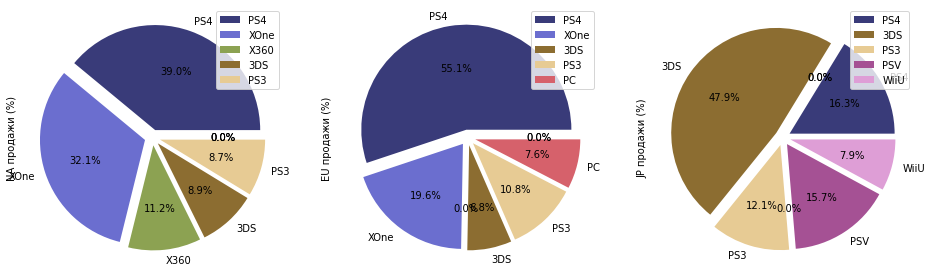

In [65]:
actual_top5_sales_platform.plot(
    kind='pie',
    figsize=(16,16),
    autopct='%1.1f%%',
    subplots=True,
    explode = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075],
    colormap= 'tab20b');

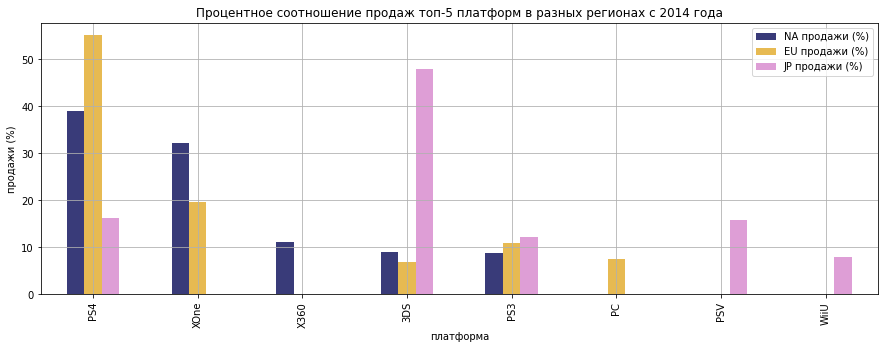

In [66]:
actual_top5_sales_platform.plot(
    kind='bar',
    figsize=(15,5),
    colormap= 'tab20b',
    grid=True,
    ylabel='продажи (%)',
    xlabel='платформа',
    title='Процентное соотношение продаж топ-5 платформ в разных регионах с 2014 года'
);

In [67]:
actual_top5_sales_platform_v2 = df_actual.pivot_table(
    index=['platform'],
    values=['na_sales','eu_sales','jp_sales'],
    aggfunc='sum'
)

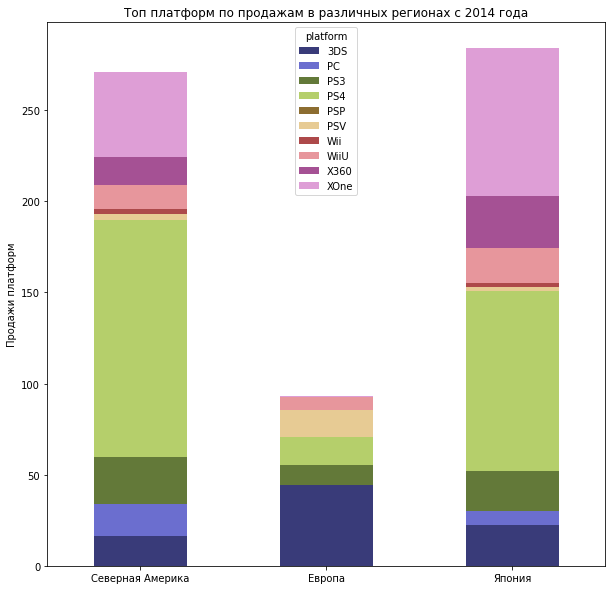

In [68]:
actual_top5_sales_platform_v2.T.plot(
    kind='bar', 
    figsize=(10,10),
    stacked=True,
    colormap= 'tab20b')

plt.title('Топ платформ по продажам в различных регионах c 2014 года')
plt.ylabel('Продажи платформ')
locs, _ = plt.xticks()
plt.xticks(locs, ['Северная Америка', 'Европа', 'Япония'], rotation=0)
plt.show();

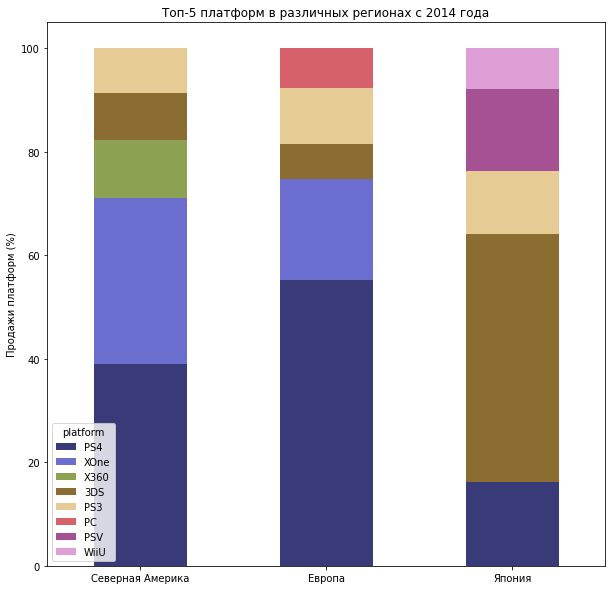

In [69]:
actual_top5_sales_platform.T.plot(
    kind='bar', 
    figsize=(10,10),
    stacked=True,
    colormap= 'tab20b')

plt.title('Топ-5 платформ в различных регионах c 2014 года')
plt.ylabel('Продажи платформ (%)')
locs, _ = plt.xticks()
plt.xticks(locs, ['Северная Америка', 'Европа', 'Япония'], rotation=0)
plt.show();

Мы видим, что 3 платформы из топ-5 каждого региона представлены во всех регионах, это: PS4, PS3 и 3DS. X360 популярна в Северной Америке. XOne в Северной Америке и Европе, а PC в Европе. Для Японского рынка популярны PSV и WiiU.

### Самые популярные жанры (топ-5).

In [70]:
actual_top5_na_sales_genre=df_actual.pivot_table(
    index='genre',
    values=['na_sales'],
    aggfunc=('sum')
    ).sort_values(
            by='na_sales',
            ascending=False
    ).head(5)

actual_top5_eu_sales_genre=df_actual.pivot_table(
    index='genre',
    values=['eu_sales'],
    aggfunc=('sum')
    ).sort_values(
            by='eu_sales',
            ascending=False
    ).head(5)

actual_top5_jp_sales_genre=df_actual.pivot_table(
    index='genre',
    values=['jp_sales'],
    aggfunc=('sum')
    ).sort_values(
            by='jp_sales',
            ascending=False
    ).head(5)

actual_top5_sales_genre = actual_top5_na_sales_genre.merge(
    actual_top5_eu_sales_genre,
    on = ['genre'],
    how = 'outer'
).merge(
    actual_top5_jp_sales_genre,
    on = ['genre'],
    how = 'outer'
)

actual_top5_sales_genre['na_sales'] = round(100 / actual_top5_sales_genre['na_sales'].sum() * actual_top5_sales_genre['na_sales'], 2)
actual_top5_sales_genre['eu_sales'] = round(100 / actual_top5_sales_genre['eu_sales'].sum() * actual_top5_sales_genre['eu_sales'], 2)
actual_top5_sales_genre['jp_sales'] = round(100 / actual_top5_sales_genre['jp_sales'].sum() * actual_top5_sales_genre['jp_sales'], 2)

actual_top5_sales_genre = actual_top5_sales_genre.rename(columns = {"na_sales" : "NA продажи (%)","eu_sales" : "EU продажи (%)","jp_sales" : "JP продажи (%)"})

actual_top5_sales_genre

,NA продажи (%),EU продажи (%),JP продажи (%)
genre,,,
Shooter,32.10,28.71,6.28
Action,29.46,32.72,38.12
Sports,18.74,20.04,NaN
Role-Playing,13.59,12.34,40.16
Misc,6.11,NaN,7.23
Racing,NaN,6.19,NaN
Fighting,NaN,NaN,8.21


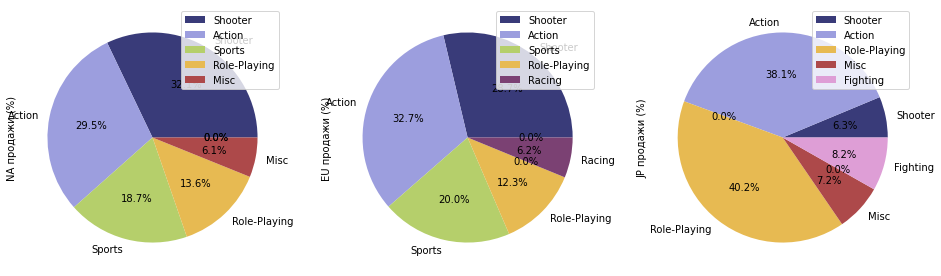

In [71]:
actual_top5_sales_genre.plot(
    kind='pie',
    figsize=(16,16),
    autopct='%1.1f%%',
    subplots=True,
    colormap= 'tab20b');

Мы видим, что 3 жанра из топ-5 каждого региона представлены во всех регионах, это: Action, Shooter и Role-Playing. Sports популярен в Северной Америке и Европе. Miscellaneous в Японии и Северной Америке. Racing в Европе.

### Влияние рейтинга ESRB на продажи в отдельном регионе.

In [72]:
actual_top5_na_sales_rating=df_actual.pivot_table(
    index='rating',
    values=['na_sales'],
    aggfunc=('sum')
    ).sort_values(
            by='na_sales',
            ascending=False
    ).head(5)

actual_top5_eu_sales_rating=df_actual.pivot_table(
    index='rating',
    values=['eu_sales'],
    aggfunc=('sum')
    ).sort_values(
            by='eu_sales',
            ascending=False
    ).head(5)

actual_top5_jp_sales_rating=df_actual.pivot_table(
    index='rating',
    values=['jp_sales'],
    aggfunc=('sum')
    ).sort_values(
            by='jp_sales',
            ascending=False
    ).head(5)

actual_top5_sales_rating = actual_top5_na_sales_rating.merge(
    actual_top5_eu_sales_rating,
    on = ['rating'],
    how = 'outer'
).merge(
    actual_top5_jp_sales_rating,
    on = ['rating'],
    how = 'outer'
)

actual_top5_sales_rating['na_sales'] = round(100 / actual_top5_sales_rating['na_sales'].sum() * actual_top5_sales_rating['na_sales'], 2)
actual_top5_sales_rating['eu_sales'] = round(100 / actual_top5_sales_rating['eu_sales'].sum() * actual_top5_sales_rating['eu_sales'], 2)
actual_top5_sales_rating['jp_sales'] = round(100 / actual_top5_sales_rating['jp_sales'].sum() * actual_top5_sales_rating['jp_sales'], 2)

actual_top5_sales_rating = actual_top5_sales_rating.rename(columns = {"na_sales" : "NA продажи (%)","eu_sales" : "EU продажи (%)","jp_sales" : "JP продажи (%)"})

actual_top5_sales_rating

,NA продажи (%),EU продажи (%),JP продажи (%)
rating,,,
M,33.94,34.52,8.60
No Rating,22.78,21.78,61.12
E,17.86,21.45,9.60
T,13.71,12.59,15.88
E10+,11.70,9.66,4.79


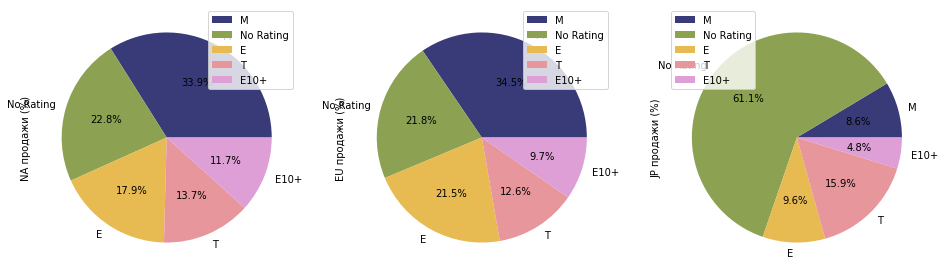

In [73]:
actual_top5_sales_rating.plot(
    kind='pie',
    figsize=(16,16),
    autopct='%1.1f%%',
    subplots=True,
    colormap= 'tab20b');

В Европе и Серверной Америке распределение продаж игр в зависимости от рейтинга схоже: Лидирует «M» («Mature» — «Для взрослых») , за ним по убывающей No Rating и «E» («Everyone» — «Для всех»).<br>
В Японии же самыми популярными являются игры без рейтинга (No Rating). Скорее всего это связано с тем, что в Японии возрастными рейтингами для игр занимается CERO – некоммерческая организация, основанная в июле 2002-го. Правила CERO невероятно строги и распространяются только на японский рынок. Стоит отметить, что Япония - это островная страна со своей самобытной культурой, обычаями и нравами. Не удивительно, что в Японии специфика игровой индустрии отличается от Европейской или Северо Американской. А многие игры выпускаются исключительно для внутреннего рынка и, значит, нет необходимости в присвоении рейтинга ESRB.

### Вывод

Мы сравнили 5 самых популярных платформ, 5 самых популярных жанров и влияние рейтинга ESRB на продажи в разных регионах. Выяснили, что рынки Северной Америки и Европы очень похожи. А вот игровая индустрия Японии имеет свои особенности.<br>
Мы основании этих сравнений мы можем составить портрет пользователя в каждом регионе:
- В Северной Америке люди предпочитают: платформу - PS4, жанр - Shooter и игры ESRB рейтига «M» («Mature» — «Для взрослых»)
- В Европе люди предпочитают: платформу - PS4, жанр - Action и игры ESRB рейтига «M» («Mature» — «Для взрослых»)
- В Японии люди предпочитают: платформу - 3DS, жанр - Role-Playing и игры без ESRB рейтига

## Проверяем гипотезы

### Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

In [74]:
df_actual_user_score_dropna = df_actual.dropna(subset=['user_score'])

Нулевая гипотеза: cредние пользовательские рейтинги платформ XOne и PC одинаковые.<br>
Альтернативная гипотеза: cредние пользовательские рейтинги платформ XOne и PC разные.

In [75]:
XOne=df_actual_user_score_dropna.query('platform=="XOne"')['user_score']
PC=df_actual_user_score_dropna.query('platform=="PC"')['user_score']

alpha = .05

results = st.ttest_ind(
    XOne, 
    PC)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средние пользовательские рейтинги платформ Xbox One и PC разные, поэтому альтернативная гипотеза верна")
else:
    print("Средние пользовательские рейтинги платформ Xbox One и PC одинаковые, поэтому нулевая гипотеза верна")

p-значение: 0.10450507919348415
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые, поэтому нулевая гипотеза верна


### Гипотеза 2. Средние пользовательские рейтинги жанров Action и Sports разные.

Нулевая гипотеза: cредние пользовательские рейтинги жанров Action и Sports одинаковые.<br>
Альтернативная гипотеза: cредние пользовательские рейтинги жанров Action и Sports разные.

In [76]:
Action=df_actual_user_score_dropna.query('genre=="Action"')['user_score']
Sports=df_actual_user_score_dropna.query('genre=="Sports"')['user_score']

alpha = .05

results = st.ttest_ind(
    Action, 
    Sports)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средние пользовательские рейтинги жанров Action и Sports разные, поэтому альтернативная гипотеза верна")
else:
    print("Средние пользовательские рейтинги жанров Action и Sports одинаковые, поэтому нулевая гипотеза верна")

p-значение: 2.8711147985105864e-19
Средние пользовательские рейтинги жанров Action и Sports разные, поэтому альтернативная гипотеза верна


### Вывод

Удалили пропуски в столбце user_score. При формулировании нулевых гипотез мы допустили, что пользовательские рейтинги равны. Выборки являются независимыми. Критический уровень статистической значимости (alpha) приняли за 0.05. Для проверки гипотез мы использовали стандартный t-тест и получили следующие результаты:
 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
 - Средние пользовательские рейтинги жанров Action и Sports разные

## Общий вывод

Исходные данные представляют собой таблицу 16715 rows × 11 columns.

При первоначальном анализе были обнаружены пропуски в столбцах: name, year_of_release, critic_score, user_score и rating. Пропуски в столбцах name и year_of_release мы удалили, т.к. их было незначительно мало и они не могли повлиять на результаты исследования. Для заполнения пропусков в столбцах critic_score, user_score мы не смогли найти подходящего способа, их пришлось оставить, дабы не навредить исследованию. Мы обнаружили характерные пропуски во всех трех столбцах (critic_score, user_score и rating), это скорее всего связано с тем, что при формировании исходного датафрейма не получилось найти информацию по этим играм, т.к. большинство из них были выпущены до 2000 года. Пропуски в столбце rating мы заполнили заглушкой "No Rating". Удалили 1 дубликат.

Мы проанализировали исходные данные и выяснили, что наибольшие продажи показала PS2, больше всего игр было выпущено в 2008 и 2009 годах. Мы выяснили, что время жизни платформы составляет 10-12 лет. Выбрали актуальный период: с 2014 по 2016 год, для формирования прогноза на 2017 год.

В период с 2014 по 2016 на рынке доминировали: PS4, ХOne, 3DS. При этом продажи игр у XOne и 3DS уже несколько лет падают, а у PS4 продажи только начали падать, значит еще несколько лет платформа будет актуальна и скоро выйдет следующее поколение.<br>

Мы рассмотрели 3 популярные платформы (PS3, PS4 и XOne), для каждой проанализировали коэф. корреляции продаж игр от оценок критиков и пользователей. И сделали вывод, что:
 - Оценки критиков демонстрируют прямую, средне-слабую корреляцию с "цифрами" продаж.
 - Оценки пользователей корреляции с продажами не имеют.<br>

Мы визуализировали распределение проданных игр по жанрам в различные годы и выяснили, что больше всего продаж в жанре Action, а меньше всего у Strategy и Puzzle. При этом больше всего прибыли в среднем приносит жанр Shooter, а меньше всего Adventure.

Мы сравнили 5 самых популярных платформ, 5 самых популярных жанров и влияние рейтинга ESRB на продажи в разных регионах. Выяснили, что рынки Северной Америки и Европы очень похожи. А вот игровая индустрия Японии имеет свои особенности. На основании этих сравнений мы составили портрет предпочтений пользователя в каждом регионе.

При анализе гипотез мы выяснили, что:
 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
 - Средние пользовательские рейтинги жанров Action и Sports разные